# Interatomic force field (IFF) optimization for W-based metal alloys

## Input data preparation

Author: Lukas Vlcek

Start Date: 2018-04-22

1. Read parameters from a pickle, and plot fpair, edens, and embed using library spline functions
2. Fit splines with given knots to another curve, which can be another spline defined by knots and coefficients.
2. Convert splines to a representation more suited for optimization

In [1]:
import sys
import os
import re
import numpy as np
from scipy.optimize import fmin
import scipy.interpolate as inter
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import copy

In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, insert_zero_params, rescale_manybody_params
from statmechlib.preprocessing import Trajectory, find_index, pair_dist_cutoff, universal_eos, downselect
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core, u_components
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [10]:
working = '../data/working'

In [46]:
# read list of param dicts
params_file = 'params_optimal'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)  

In [47]:
stats_file = 'stats_manyall' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

In [48]:
S = []
for pars in param_list:
    pair_knots = pars['hyperparams']['pair']
    edens_knots = pars['hyperparams']['edens']
    stats = downselect(stats_all, pair_knots, edens_knots)
    S.append(1.0/u_components(pars, stats['relax'])['edens'][0])
    print(1/S[-1], S[-1])

(4.1226644289869725, 0.24256158055670846)
(8.4455197198155538, 0.11840597537813097)
(12.718099807833058, 0.078628098152217801)
(4.1226644289869725, 0.24256158055670846)
(11.406728376622763, 0.087667556110955114)
(4.1226644289869725, 0.24256158055670846)
(12.498726650995298, 0.080008150263880529)
(42.707292660781107, 0.023415204703863574)
(6.6986928316800123, 0.14928285639113309)


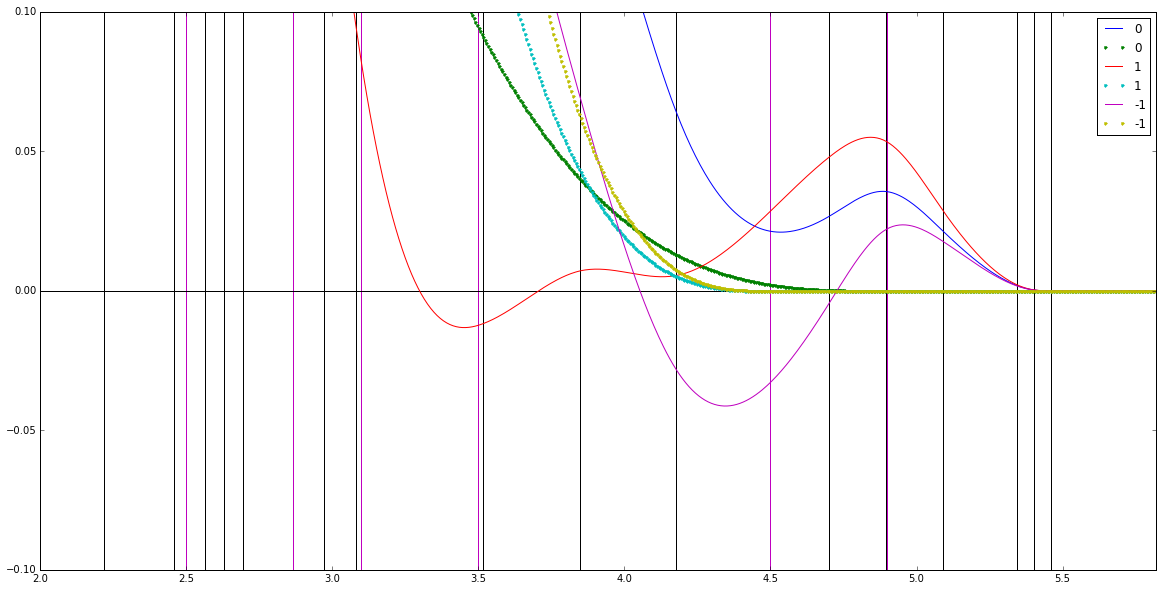

In [51]:
plt.figure(figsize=(20,10))
for i in [0, 1, -1]:
    params = param_list[i]
    knots_pair = params['hyperparams']['pair']
    coeff_pair = params['params']['pair']
    knots_edens = params['hyperparams']['edens']
    coeff_edens = params['params']['edens']
    embed = params['params']['embed']
    
    rs = np.linspace(2, 5.82, 701)
    y_pair = [f_spline3(r, coeff_pair, knots_pair) for r in rs]
    y_edens = [f_spline3(r, coeff_edens, knots_edens) for r in rs]
    
#    plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
    plt.vlines(params['hyperparams']['pair'], -10, 10)
    plt.vlines(params['hyperparams']['edens'], -10, 10, colors='m')
    
    plt.plot(rs, y_pair, '-', label=str(i))
    plt.plot(rs, y_edens, '.', label=str(i))
    
    plt.xlim(2.0, 5.82)
    plt.ylim(-0.1,0.1)
    plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()

(0, array([-5.946454, -0.049477]))
(0, 1.8722845236273526, 0.24256158055670846)
(1, array([ -3.89054208e+00,  -2.99469508e-03]))
(1, 0.71995457162800036, 0.11840597537813097)
(-1, [-4.65804603, -0.00756457588])
(-1, 1.0012134163086182, 0.14928285639113309)


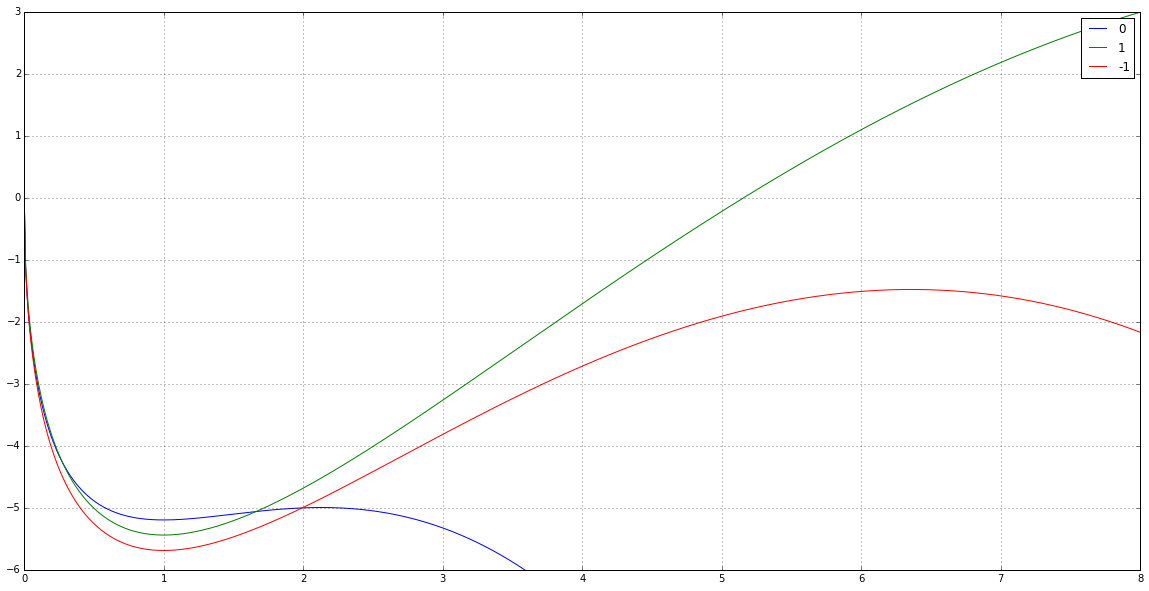

In [52]:
#S = [1./4.12265151, 1./8.44551209, 1./12.71800096]
plt.figure(figsize=(20,10))
for i in [0, 1, -1]:
    params = param_list[i]
    embed = params['params']['embed']
    rs = np.linspace(0, 10, 1001)
    #F = [f_embed(r, embed) for r in rs]
    print(i, embed)
    
    A = params['params']['embed'][0]
    B = params['params']['embed'][1]
    
    C = (-A/2.0/np.sqrt(S[i]) - 2*B/S[i]**2)*S[i]
    
    print(i, C, S[i])
    
    F = [f_embed(r/S[i], [A, B]) + r/S[i]*C for r in rs]
    
    plt.plot(rs, F, '-', label=str(i))
    
    #F = [f_embed(r/0.223232, embed) for r in rs]
#     A = [-5.946454, -0.049477]
#     Fx = lambda d, a: a[0]*d**0.5 + a[1]*d**2 #+ 1.848055990*d
#     d = np.linspace(0., 8., 101)
#     plt.plot(d, [Fx(x/0.223232, A) for x in d])
    #plt.plot(rs, F, '-', label=str(i))

    plt.xlim(0, 8)
    plt.ylim(-6,3.0)
    plt.grid(True)
    
#     plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()

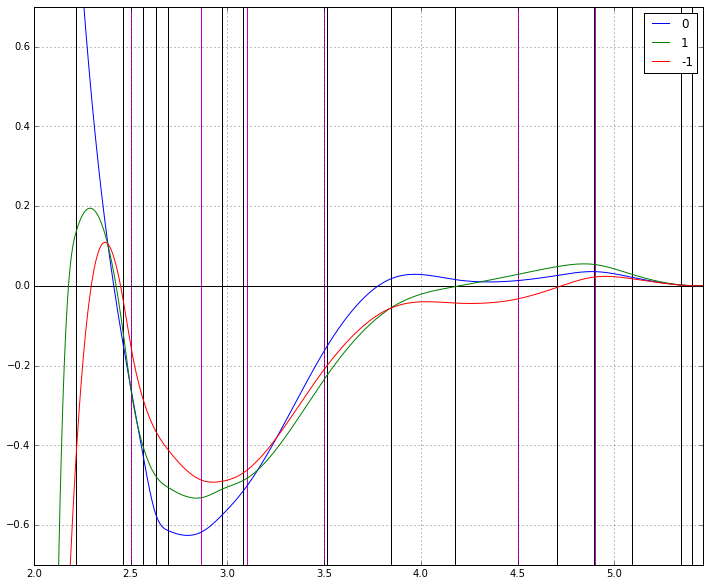

In [53]:
#S = [1./4.12265151, 1./8.44551209, 1./12.71800096]

plt.figure(figsize=(12,10))
for i in [0, 1, -1]:
    params = param_list[i]
    knots_pair = params['hyperparams']['pair']
    coeff_pair = params['params']['pair']
    knots_edens = params['hyperparams']['edens']
    coeff_edens = params['params']['edens']
    embed = params['params']['embed']
    
    A = params['params']['embed'][0]
    B = params['params']['embed'][1]
    
    C = (-A/2.0/np.sqrt(S[i]) - 2*B/S[i]**2)*S[i]
    
    rs = np.linspace(2, 5.82, 701)
    y_pair = np.array([f_spline3(r, coeff_pair, knots_pair) for r in rs])
    y_edens = np.array([f_spline3(r, coeff_edens, knots_edens) for r in rs])
    
#    plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
    plt.vlines(params['hyperparams']['pair'], -10, 10)
    plt.vlines(params['hyperparams']['edens'], -10, 10, colors='m')
    
    plt.plot(rs, y_pair - 2.*C*y_edens, '-', label=str(i))
    #plt.plot(rs, y_pair, '-', label=str(i))

    #plt.plot(rs, y_edens, '.', label=str(i))
    
    plt.xlim(2.0, 5.46)
    plt.ylim(-0.7,0.7)
    plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()
plt.grid(True)

In [573]:
params = param_list[-1]
knots_pair = list(params['hyperparams']['pair'])
coeff_pair = list(params['params']['pair'])
knots_edens = params['hyperparams']['edens']
coeff_edens = params['params']['edens']
print(knots_pair)
print(knots_edens)
print(coeff_pair)

[2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003]
[2.5, 2.8663175000000001, 3.1000000000000001, 3.5, 4.5, 4.9000000000000004]
[-760.32509100000004, 225.92242100000001, 43.168213899999998, -20.087958700000001, 31.597729900000001, -14.121638300000001, 14.072954899999999, -0.22974106899999999, 0.566020784, 0.95081336999999999, -0.70787750599999999, -0.63388597599999996, 2.1151412999999999, -1.0708453499999999, -0.19947135799999999, -1.53976066, 1.5474957899999999]


In [572]:
print(knots_edens, knots_, param_list[1]['params']['embed'])

([2.2200000000000002, 2.5, 2.6946924999999999, 2.8663175000000001, 3.1000000000000001, 3.5, 4.6200000000000001, 4.9000000000000004], array([ 43.3363673 ,  60.4909283 ,  40.4214288 , -23.4985547 ,
        10.3464548 ,   0.209124  ,   0.11044082,   0.        ]), array([ -3.89054208e+00,  -2.99469508e-03]))


In [570]:
rs = np.linspace(2.2, 5.66, 347)
rs = np.linspace(2.2, 5.1, 261)
print(rs[-1])


y_pair = [f_spline3(r, coeff_pair, knots_pair) for r in rs]

y_pair += [0.0 for _ in np.linspace(5.11, 5.20, 10)]
y_pair += [-0.03 for _ in np.linspace(5.21, 5.56, 36)]
y_pair += [0.0 for _ in np.linspace(5.561, 5.66, 10)]

rs = np.linspace(2.2, 5.66, 347)
print(len(rs), len(y_pair))
#y_edens = [f_spline3(r, coeff_edens, knots_edens) for r in rs]

#loss = lambda p, x, y, k: sum([(yi - f_spline3(xi, p, k))**2 for xi, yi in zip(x, y)])

def loss(p, x, y, k):
    ls = sum([(yi - f_spline3(xi, p, k))**2 for xi, yi in zip(x, y)])
    print(ls)
    return ls

5.1
(347, 317)


In [559]:
y_pair


[9.3454276273768713,
 8.8939016397947341,
 8.4601664087260247,
 8.0452472464563769,
 7.6487907598402813,
 7.2702611029480408,
 6.9091224298499085,
 6.5648388946161731,
 6.2368746513171303,
 5.9246938540230261,
 5.6277606568041705,
 5.345539213730838,
 5.0774936788733172,
 4.8230882063018541,
 4.5817869500867587,
 4.3530540642983269,
 4.1363537030067832,
 3.9311500202824732,
 3.7369071701956216,
 3.5530893068165312,
 3.3791605842154979,
 3.2145851564627961,
 3.0588271776286717,
 2.911350801783442,
 2.7716270247678878,
 2.6392000912730254,
 2.5136586798684561,
 2.3945920925800976,
 2.2815896314338531,
 2.1742405984556612,
 2.0721342956714182,
 1.974860025107084,
 1.8820070887885336,
 1.7931661447498186,
 1.7080466646043462,
 1.6265678264171797,
 1.5486702033936623,
 1.4742943687391445,
 1.4033808956589482,
 1.3358622697680502,
 1.2714522454068913,
 1.2096259602494293,
 1.1498464778587305,
 1.0915768617979289,
 1.0342801756301121,
 0.97745105413574862,
 0.92097679361371121,
 0.86501075504

In [560]:
import copy

knots_pair_new = copy.deepcopy(knots_pair)
knots_pair_new[:] = knots_pair_new[0:5] + [2.74] + knots_pair_new[5:-2] + [5.66, 5.70, 5.78]

coeff_pair_new = copy.deepcopy(coeff_pair)
coeff_pair_new[:] = coeff_pair_new[0:5] + [0.0] + coeff_pair_new[5:-2] + [0.0, 0.0, 0.0]

# knots_pair_new = []
# knots_pair_new[:] = knots_pair[0:5] + [2.74] + knots_pair[5:]

# coeff_pair_new = []
# coeff_pair_new[:] = coeff_pair[0:5] + [0.0] + coeff_pair[5:]

print(knots_pair_new)
print(coeff_pair_new)

[2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.74, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.66, 5.7, 5.78]
[-263.564571, 15.0313698, 42.190757099999999, -57.353106400000001, 83.516536599999995, 0.0, -36.978802600000002, 9.5874977900000005, 6.1684507899999996, 2.4923851300000002, 0.23987957700000001, -0.70824024500000005, -1.04050858, 2.2938386199999998, -0.70711427500000001, -0.27230465500000001, 0.0, 0.0, 0.0]


In [561]:
new_pair = fmin(loss, coeff_pair_new, args=(rs, y_pair, knots_pair_new), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)

print(coeff_pair_new)
print(new_pair)

30.8962822098
30.8961331068
31.0301183793
32.3969931821
27.4976094911
42.3107105544
30.8970815415
20.5502852125
37.5696411768
37.8758557094
43.7060425502
33.3017406176
20.499697564
16.8033185795
332.183590668
21.9701643269
19.8695832885
31.357020213
31.3715383471
31.4013069207
152.176294013
35.5784347655
14.8729439127
16.7332298138
15.514621481
15.013040842
15.1288492079
87.2197413889
17.995210931
15.3747354812
15.8042320492
16.5620882958
17.7428968351
19.6674997482
22.1361405998
25.946620113
31.3047898745
19.4228550369
32.9826779187
19.2251091445
31.5091840594
18.1723051041
26.5104712786
18.1751609516
23.1403252172
17.1729514241
16.2251418473
23.4766602417
16.3571778782
22.309619302
16.4824926189
13.9594132844
15.9248512707
18.912551292
17.6695030848
18.8696844278
23.2726196944
15.4942226056
18.7833948547
15.9493409295
16.450100329
17.4545052935
13.8848795411
15.2721426888
15.622052158
19.1852699513
15.189155163
19.7222293348
15.0641143308
16.4354471926
17.3403443189
15.0760022454
16.

0.588053178592
0.59445263112
0.600878911005
0.592304076803
0.590406561957
0.583033085335
0.598027011524
0.59749739055
0.607991203503
0.576590934424
0.586972717333
0.563321103523
0.55207382408
0.6118148954
0.589784718659
0.574925975325
0.597854097701
0.563421883382
0.593111441579
0.583866035061
0.577930579875
0.567267630245
0.571768614137
0.580045481206
0.559467177459
0.563739988359
0.577122673751
0.604641013676
0.573321147586
0.553225062771
0.566283465447
0.555674345538
0.570052565117
0.565041096797
0.555773595088
0.561905347645
0.551260894623
0.570553393367
0.565496781762
0.549701366325
0.567446415905
0.568412772183
0.550818846529
0.554512501081
0.547846559662
0.569541098736
0.552403759375
0.558280784121
0.561053884461
0.546139499628
0.567629990512
0.558169688336
0.563753815943
0.559245856996
0.56890966795
0.548901257857
0.558452114138
0.551012767919
0.550450933929
0.551747434212
0.548163892524
0.565091912528
0.545856187905
0.556482871741
0.559042504905
0.546114480589
0.558581650139
0

0.23499577321
0.233934065478
0.2351805933
0.233909581947
0.235605119475
0.233817329578
0.234165379574
0.234825054117
0.233873603855
0.235307351997
0.233783436834
0.236131419873
0.233689986644
0.233825129905
0.234205756928
0.233964591592
0.235565114326
0.233620541264
0.234752994355
0.23369143537
0.235033580635
0.233637429864
0.232925070148
0.232655094894
0.233229391972
0.233352959723
0.234095544338
0.233010870094
0.234207763316
0.23346803366
0.233997179161
0.234447779641
0.233390449906
0.234440770583
0.23338850047
0.234094252045
0.233420905707
0.234168616937
0.233401144379
0.233312438429
0.232895562835
0.23259524955
0.232265465705
0.233544372652
0.233132291551
0.232854694885
0.232761775088
0.232990467848
0.232989858069
0.232815768957
0.23221255898
0.231942848917
0.232713273719
0.232281671913
0.232260775622
0.231986720815
0.231643420215
0.231032682117
0.231868962799
0.232042443813
0.231976444117
0.231499586558
0.23200064566
0.231589036688
0.231465916378
0.231637328161
0.230678887956
0.22

0.192448304289
0.192456212514
0.192440828461
0.19240474654
0.192425069248
0.192433473306
0.192406576083
0.192403873659
0.192357982489
0.192393731937
0.192403734645
0.192367639148
0.192355504304
0.192292506858
0.192341355572
0.192336163494
0.192357065819
0.192315281951
0.19229471612
0.192283008606
0.192203615075
0.192260852571
0.192245154918
0.192257439298
0.192211917269
0.19222593789
0.192208607122
0.192180185429
0.192082901742
0.192187915765
0.192200096964
0.192139887248
0.192143539918
0.192118384762
0.192116946496
0.19207961548
0.191984733795
0.192073435734
0.192048485388
0.192019699888
0.191993985932
0.192001191181
0.192001107812
0.191965968877
0.191862758771
0.191914820119
0.191929336968
0.191893815528
0.19189370667
0.191852953252
0.191728600753
0.191876779332
0.191764092746
0.191759669493
0.191782609196
0.19173122034
0.191727915432
0.191629644177
0.19169828733
0.191648802324
0.191639658417
0.191617855594
0.191472598978
0.191589381824
0.191515902418
0.191500048546
0.191556444821
0.

0.128495847773
0.128824725471
0.130083261245
0.129103286595
0.128370331308
0.128856868634
0.128926621618
0.130191631615
0.129116703765
0.128881570659
0.129562215722
0.12857361918
0.129816921123
0.127797051259
0.127673028993
0.129167898483
0.129775702173
0.128730613096
0.127963232441
0.128619834201
0.128677669181
0.12909864239
0.128397523231
0.128412500744
0.128067540463
0.130373622339
0.128153479073
0.127829465645
0.127770289034
0.1293277097
0.12815129049
0.12726292566
0.127380586476
0.127762065436
0.128224784189
0.126952343473
0.12674754772
0.127142223811
0.12794437768
0.12767409547
0.126783298787
0.127840870015
0.126979563236
0.127618366805
0.127857711475
0.127160300798
0.127338864741
0.126700000444
0.127321597655
0.126743398174
0.126820020247
0.126592476013
0.127419316947
0.127070521057
0.127715464494
0.127980628155
0.126960555519
0.127068833574
0.127292845206
0.126712562347
0.127236671647
0.126745209711
0.126616415568
0.126743685016
0.126907199794
0.127628934675
0.126575384505
0.12

0.126104910083
0.126104921222
0.126105462454
0.12610588713
0.126104967297
0.126105860377
0.126105703444
0.126104809038
0.126104773705
0.126104241497
0.126103607497
0.126106002157
0.126104853793
0.126104500685
0.126104597914
0.126106037389
0.126104589656
0.126103109767
0.1261020692
0.126103273136
0.126104506438
0.126104430799
0.126103484443
0.126103082856
0.126104133861
0.126102782105
0.126102635001
0.126101526747
0.126100071907
0.12610219427
0.126102320327
0.126104592702
0.126102090802
0.126102907293
0.126102293304
0.126100941544
0.126103047263
0.12610007788
0.126100842531
0.126100015925
0.12609936645
0.126101905462
0.12609963529
0.126098796219
0.126096886602
0.126099632999
0.126099693394
0.126100322151
0.126101893965
0.126099573114
0.126098066791
0.126098320586
0.126097651671
0.126098224332
0.126096469402
0.126094508282
0.126096582168
0.126095581976
0.126096090153
0.126098158707
0.12609503054
0.126096730566
0.126096341149
0.126095263008
0.126093795249
0.12609174143
0.1260937819
0.1260

0.116610035233
0.116588763508
0.116358925511
0.116545157299
0.116286834426
0.116423917054
0.116210750854
0.116263874377
0.11668539931
0.116345910616
0.116638861502
0.116468177965
0.116280106864
0.116911494504
0.116468178298
0.116309028815
0.116533269864
0.11609391205
0.116171558445
0.116318734049
0.116081353041
0.11625536
0.116914765683
0.116316793753
0.11589520296
0.11573734239
0.11597094478
0.116218697546
0.116025012427
0.115771564853
0.116170756917
0.116060192045
0.116448598879
0.115991476774
0.11640467897
0.115765111894
0.116307286404
0.115711900125
0.115707804015
0.115627986166
0.115591557551
0.115632796493
0.115588563912
0.115707352387
0.115685401737
0.116097576893
0.115623249079
0.115333449749
0.115255258408
0.115647264113
0.115176377732
0.115016920863
0.115880424158
0.115798787047
0.115158726589
0.115482909301
0.115177014631
0.115145863973
0.115185615426
0.115001842493
0.115183075731
0.115470396881
0.115386683345
0.114835357379
0.114749750122
0.11483258626
0.11479250567
0.11484

0.113127792009
0.1131277029
0.113127814136
0.113127700007
0.113127754381
0.113127705657
0.113127806385
0.113127693894
0.113127757145
0.113127674001
0.11312780409
0.113127687907
0.113127771761
0.113127688335
0.113127736535
0.113127756566
0.113127687564
0.113127776827
0.113127684512
0.113127759605
0.113127686222
0.113127729849
0.113127678014
0.113127744993
0.113127680495
0.113127689408
0.113127730217
0.113127677667
0.113127715791
0.11312766762
0.113127714235
0.113127723503
0.113127670656
0.113127663833
0.113127722361
0.11312766829
0.113127671398
0.113127706242
0.113127665497
0.113127659441
0.113127679146
0.113127667968
0.113127732356
0.113127653463
0.113127672047
0.113127656516
0.113127670077
0.113127676338
0.113127657613
0.113127672224
0.113127673105
0.113127682615
0.11312765069
0.11312763526
0.113127659796
0.113127660106
0.113127681226
0.113127647198
0.113127671531
0.113127674657
0.113127647226
0.113127653864
0.113127669255
0.113127721733
0.113127641094
0.113127655007
0.113127675081
0.

0.11310336047
0.113101996843
0.113101992902
0.113100912921
0.113099507661
0.113099750744
0.113100450595
0.113100124214
0.113100498319
0.113100706538
0.11309994277
0.113099138566
0.11309742273
0.113099678041
0.113098613238
0.11309803778
0.113099236231
0.113097744389
0.113097258039
0.113095690147
0.11309621606
0.113096026387
0.113097311257
0.113096044387
0.113095615967
0.113094737935
0.113094414357
0.113092457584
0.113093702567
0.113094494228
0.113094349411
0.113092831859
0.113091793429
0.113088380747
0.113093143749
0.113092960623
0.113091050377
0.113090707634
0.113089396083
0.113089255298
0.113090063683
0.113089198033
0.113087945061
0.113085760924
0.113087315026
0.113086510843
0.11308725829
0.113085156274
0.113082029186
0.113088425726
0.113083892146
0.113084092659
0.113086089364
0.113082494815
0.113082405965
0.113082030855
0.113081769441
0.113081026246
0.113081137959
0.113080180919
0.113078352896
0.113077693518
0.113072722192
0.113078331689
0.113077067747
0.113077773672
0.113081193747
0

0.109563757869
0.109889191238
0.109683733634
0.109538138289
0.109693599518
0.10952955178
0.109660710872
0.10940990431
0.109378044825
0.109487363393
0.109450164823
0.109472220261
0.109340231301
0.109468809294
0.10949341273
0.109574596137
0.109288583468
0.109336304588
0.10978492606
0.109254408117
0.109299481614
0.109692592175
0.109098143738
0.108925711202
0.109228274614
0.109425808806
0.109134294112
0.10967621436
0.109361280677
0.109620771305
0.109342789397
0.109113689409
0.109329062547
0.109299648001
0.108938588122
0.109019489562
0.10906173023
0.109175101918
0.108921907137
0.108959520094
0.109087246345
0.108984618571
0.108966705216
0.108971899743
0.109023745874
0.109022603232
0.108806731193
0.108905418106
0.108824141804
0.108955500845
0.108756293953
0.108909888717
0.108765622483
0.108924130283
0.108908380915
0.108784929821
0.108777530838
0.108791583694
0.108630649304
0.108684102922
0.108919033399
0.108818642615
0.108580679467
0.108603428434
0.108776849103
0.108873519615
0.108801311331
0

0.0911878660665
0.0905279724999
0.0906424988035
0.0913123195819
0.0912010151899
0.0912355125332
0.0910866210902
0.0905365774706
0.0914327562135
0.0908371641774
0.0908135430858
0.091215152219
0.0908048238339
0.091118140553
0.091331728854
0.090785478437
0.0910843104016
0.0905304125195
0.0911124741298
0.0904980919211
0.0907739612018
0.0909557461982
0.0911336414653
0.0907181702728
0.090441794771
0.0907118382223
0.0909972512058
0.090987349681
0.0912123286308
0.0906634439559
0.0907329790387
0.090318076372
0.0904224662283
0.0907920608865
0.0910960175281
0.090603275077
0.0909129315691
0.0904033245176
0.0907255932467
0.0905394131441
0.0907254702828
0.0902174392238
0.0902921064404
0.0905413978806
0.0902733386874
0.0907063574698
0.0902841771739
0.0907105922334
0.0907031990767
0.0907689442594
0.0904100690263
0.0903939690366
0.0906579061521
0.090855508985
0.0903796307609
0.0906551710947
0.0900324220191
0.089933724704
0.0906071176419
0.0906255272329
0.0903330913557
0.0906438827643
0.090327475556
0.0

0.0897279733837
0.089727975941
0.0897279734048
0.0897279754812
0.0897279733602
0.089727976002
0.0897279732946
0.0897279740069
0.0897279759824
0.089727973135
0.0897279743042
0.0897279746457
0.089727973048
0.0897279741503
0.0897279756609
0.0897279728995
0.0897279743458
0.0897279755572
0.0897279728969
0.0897279743375
0.0897279742719
0.0897279745917
0.0897279729689
0.0897279749947
0.0897279729136
0.0897279745569
0.0897279729624
0.0897279743296
0.0897279729767
0.089727973717
0.0897279744616
0.0897279729224
0.0897279743737
0.089727972907
0.0897279745073
0.0897279728414
0.0897279741785
0.0897279728524
0.0897279743492
0.0897279727954
0.0897279738017
0.089727972846
0.0897279736812
0.0897279745917
0.0897279727307
0.0897279736688
0.0897279728166
0.08972797306
0.0897279733319
0.0897279732787
0.0897279734279
0.0897279727046
0.0897279732848
0.0897279727014
0.0897279733337
0.0897279726941
0.0897279729126
0.0897279732608
0.0897279726152
0.0897279732288
0.0897279726153
0.0897279727364
0.0897279729601
0

0.0897279009555
0.0897278999735
0.0897278982822
0.0897278999719
0.089727897857
0.0897278958672
0.0897278928539
0.0897278828727
0.089727891117
0.0897278919903
0.0897278905541
0.0897278867314
0.0897278879735
0.0897278838631
0.0897278815572
0.0897278691708
0.0897278804983
0.0897278766465
0.0897278750439
0.0897278779204
0.0897278740462
0.089727873662
0.0897278738896
0.0897278678658
0.0897278544178
0.0897278647525
0.089727863111
0.089727861048
0.0897278590121
0.089727860974
0.0897278556188
0.0897278551959
0.0897278549808
0.0897278502588
0.089727836929
0.0897278503347
0.0897278444347
0.0897278426081
0.0897278416709
0.0897278405026
0.089727837355
0.0897278341848
0.0897278174321
0.0897278279611
0.0897278291911
0.0897278242758
0.0897278237419
0.0897278233976
0.0897278242469
0.0897278179633
0.0897278149511
0.0897277983369
0.089727812642
0.0897278114409
0.0897278048971
0.0897278082569
0.0897277960077
0.0897277709103
0.0897278006271
0.0897277961398
0.0897277954299
0.0897277865778
0.0897277847198
0

0.089718995574
0.089718632301
0.0897185682349
0.0897186209189
0.0897187314627
0.0897187835329
0.0897185216847
0.0897184850028
0.089718777153
0.0897184443504
0.0897183819534
0.0897188581581
0.0897186749098
0.0897185992776
0.0897183744628
0.0897183961359
0.0897186454653
0.0897183608787
0.0897184240284
0.0897183922373
0.0897182221262
0.0897181563124
0.0897181906174
0.0897185111038
0.089718245496
0.0897180618855
0.0897179618838
0.0897181280329
0.0897182580317
0.0897179669466
0.0897181094655
0.0897181275338
0.0897182478448
0.0897182463998
0.0897179687765
0.0897177769054
0.0897177795404
0.0897178370674
0.0897180176495
0.0897179049527
0.0897182144905
0.0897176980111
0.0897177357844
0.0897176575634
0.0897177120969
0.089717491631
0.0897173192998
0.0897176745476
0.0897179725821
0.0897175450338
0.0897176032806
0.0897179411285
0.0897179759208
0.0897176351799
0.0897173825902
0.0897177054176
0.0897175091238
0.0897174234255
0.0897177643091
0.0897176776317
0.0897172585636
0.0897173221034
0.08971703886

0.0896782475628
0.0896781359159
0.0896805599029
0.089679645847
0.0896802938881
0.0896791568418
0.0896776672743
0.0896797347237
0.0896805882179
0.0896770190642
0.0896781671027
0.0896817374333
0.0896786160307
0.0896807721783
0.0896769472171
0.0896783297154
0.0896784252938
0.0896780347064
0.0896811684399
0.0896782596812
0.0896804296933
0.0896785051751
0.0896803601596
0.0896752219097
0.0896743630264
0.089679265
0.0896784913019
0.0896758522203
0.0896796930204
0.0896773652567
0.0896752797526
0.089676738623
0.0896791926738
0.0896769858535
0.0896756913774
0.0896759962476
0.0896783857348
0.0896781117697
0.089678087507
0.0896768364657
0.0896778338604
0.0896744872772
0.0896740503956
0.0896739093214
0.0896743299384
0.0896771130566
0.0896774197238
0.0896760037185
0.0896764019891
0.0896729311827
0.0896722870349
0.0896737953973
0.0896757093565
0.0896745361048
0.0896756491651
0.0896735960794
0.0896719321805
0.0896716765998
0.0896720226645
0.0896738494212
0.0896713795739
0.0896721040663
0.0896727711131

0.0894053063177
0.0894115160164
0.0893925161964
0.089395905075
0.0894060807029
0.0893928659093
0.0893913197363
0.0893967969671
0.0893933879109
0.0893808294394
0.0893723842894
0.0893914619575
0.0894005267517
0.0893826114662
0.0893889180214
0.0893761879662
0.0893857966061
0.0893755914203
0.0893854748671
0.0893790628423
0.089367094434
0.0893633520889
0.0893626605191
0.0893580942485
0.0893784091848
0.0893610979403
0.0893705672959
0.0893647567687
0.0893605200768
0.0893514318138
0.0893433681578
0.0893470357342
0.0893448860563
0.0893458122383
0.0893410471758
0.0893416518131
0.0893374214454
0.0893360020624
0.0893470416524
0.0893371803586
0.0893364289468
0.0893392965578
0.0893308822701
0.0893429607605
0.0893272846711
0.0893371752615
0.0893289011577
0.089310345695
0.089297839264
0.089316859063
0.0893082483913
0.0893188938724
0.0893100086554
0.0892889778892
0.0892672577026
0.0892901995537
0.0892934653404
0.0892841130567
0.089297767426
0.0892960559719
0.0892761740773
0.0892905082894
0.089261122234

0.0796840184921
0.0792450689499
0.0793822793826
0.0795140445848
0.0792508639785
0.0795557737022
0.0796786559943
0.0796636821062
0.0797405188652
0.0793977170158
0.079375207649
0.0797449689339
0.0793807175896
0.0791667635169
0.0793045025478
0.0795242729791
0.0790519742097
0.0790522812418
0.0795494150503
0.0790812774977
0.0790800389899
0.0792105416594
0.0790359411727
0.07920280182
0.0793252111175
0.0794709179009
0.0793383530717
0.079207297555
0.0789988960014
0.0792211387974
0.079599606506
0.0791609914723
0.0789710576719
0.0791103493212
0.0790941033962
0.0789358893463
0.079090329124
0.0789358680005
0.0791355807649
0.0791035943268
0.079220471471
0.0790635162662
0.078948352726
0.0788600202196
0.0790119991705
0.0788981726492
0.0788496650893
0.0790821513525
0.0791160737827
0.0789855669055
0.0790950649884
0.0787601010143
0.078861235116
0.0787557132251
0.0789033096854
0.0791519189323
0.0788984687784
0.0790204469868
0.0791376864251
0.0788893152135
0.0789900594766
0.0787669482494
0.0787940725113
0

0.0782296232159
0.0782293545204
0.0782299536294
0.0782295808904
0.0782300818169
0.078229500558
0.0782294696855
0.0782300451293
0.0782294629454
0.0782299409825
0.0782295663023
0.0782291825323
0.0782297953765
0.0782296508316
0.0782299661851
0.0782293829313
0.0782294468857
0.0782297728448
0.0782290769884
0.0782296103881
0.078229726063
0.0782292739323
0.0782298346583
0.0782292655184
0.0782292354684
0.0782291245976
0.078229664298
0.0782292220298
0.0782294004643
0.0782295054493
0.0782289454254
0.0782292601271
0.0782295338171
0.0782297200238
0.0782291491186
0.0782295535561
0.0782291561334
0.0782293669903
0.0782294352787
0.0782289127209
0.0782292185156
0.0782294150682
0.0782288697575
0.0782291487219
0.0782292973844
0.0782293512912
0.0782294602042
0.0782290594096
0.0782295426546
0.0782290451219
0.078228846832
0.0782291182199
0.0782292695703
0.0782289808492
0.0782293199477
0.0782289985795
0.0782293659892
0.0782289886646
0.0782288055275
0.078229036991
0.078229232151
0.0782286915738
0.078228770255

0.0782281991452
0.0782281993258
0.0782281991463
0.0782281992542
0.0782281992545
0.0782281991437
0.0782281992487
0.0782281991427
0.0782281992262
0.078228199174
0.0782281992125
0.0782281992106
0.0782281991906
0.0782281992268
0.0782281991275
0.0782281992112
0.0782281991285
0.0782281992202
0.078228199126
0.0782281992028
0.0782281991255
0.0782281991842
0.0782281991336
0.0782281992344
0.0782281991159
0.0782281991987
0.0782281991177
0.0782281992341
0.0782281991103
0.0782281991574
0.0782281991265
0.0782281991335
0.0782281991305
0.0782281991665
0.078228199108
0.0782281991542
0.078228199108
0.078228199162
0.078228199105
0.0782281991327
0.0782281991694
0.0782281991031
0.0782281991684
0.078228199103
0.0782281991506
0.0782281991045
0.0782281990999
0.0782281991681
0.0782281991341
0.0782281991012
0.0782281991725
0.0782281990969
0.078228199172
0.0782281990972
0.0782281991387
0.0782281991008
0.0782281991561
0.0782281990981
0.0782281991078
0.078228199105
0.0782281991356
0.0782281990974
0.0782281990966
0

0.0782281990219
0.0782281990164
0.0782281990239
0.0782281990195
0.0782281990202
0.0782281990221
0.0782281990189
0.0782281990212
0.0782281990178
0.0782281990164
0.0782281990165
0.0782281990187
0.078228199013
0.0782281990068
0.0782281990143
0.0782281990091
0.0782281990109
0.0782281990192
0.0782281990121
0.0782281990106
0.07822819901
0.0782281990083
0.0782281990072
0.0782281990067
0.0782281990043
0.0782281990037
0.0782281989981
0.0782281990048
0.078228199005
0.0782281990057
0.0782281990008
0.0782281990028
0.0782281989999
0.0782281989995
0.0782281989955
0.0782281989896
0.0782281989939
0.0782281989945
0.0782281989924
0.078228198991
0.078228198991
0.0782281989892
0.0782281989844
0.0782281989943
0.0782281989846
0.0782281989894
0.0782281989865
0.0782281989978
0.0782281989813
0.0782281989731
0.0782281989788
0.0782281989806
0.0782281989817
0.0782281989765
0.0782281989757
0.0782281989716
0.078228198962
0.0782281989836
0.0782281989777
0.0782281989724
0.0782281989687
0.078228198966
0.078228198971
0

0.0782281871328
0.0782281875607
0.0782281879904
0.0782281877714
0.0782281880999
0.0782281882958
0.0782281874977
0.0782281875078
0.0782281867547
0.078228186107
0.0782281868171
0.0782281876013
0.0782281862232
0.078228186437
0.0782281860901
0.0782281857097
0.0782281864181
0.0782281858656
0.0782281878429
0.0782281859671
0.078228186135
0.0782281862195
0.0782281856167
0.0782281858116
0.0782281860109
0.0782281863065
0.0782281859561
0.0782281853778
0.0782281859972
0.0782281854146
0.0782281856579
0.078228184559
0.0782281842899
0.07822818439
0.078228184126
0.0782281837407
0.0782281846998
0.0782281854963
0.0782281837321
0.0782281829457
0.0782281863024
0.07822818514
0.0782281844985
0.078228183884
0.0782281836755
0.0782281841773
0.0782281837074
0.0782281837964
0.0782281848291
0.0782281837987
0.0782281828097
0.0782281825146
0.0782281820792
0.0782281809648
0.078228183109
0.0782281823124
0.0782281843938
0.0782281813491
0.0782281810874
0.0782281827354
0.0782281820828
0.0782281808234
0.0782281797711
0.0

0.0782267807578
0.0782267254999
0.0782267736377
0.0782267847071
0.0782267976307
0.0782267533272
0.0782267778637
0.0782267725101
0.0782267196776
0.0782268577323
0.0782267236141
0.0782267413056
0.0782267116565
0.0782268736938
0.0782266574467
0.0782267168046
0.0782266357921
0.0782266764614
0.078226708751
0.0782266682653
0.0782267012802
0.0782266587405
0.0782266779339
0.078226623008
0.0782266965808
0.0782266661232
0.0782267116473
0.0782265943569
0.0782266510256
0.0782266123062
0.0782266342046
0.0782266157785
0.0782266088457
0.0782266591831
0.0782266000166
0.0782266619889
0.0782266358803
0.0782265662465
0.0782266622347
0.0782266395444
0.0782265256763
0.0782265729958
0.0782265910389
0.0782265815165
0.0782265936505
0.0782265923918
0.0782267002418
0.0782265727232
0.0782266329609
0.0782265247068
0.0782266003603
0.0782265622413
0.0782266529819
0.078226560383
0.0782266573195
0.0782265585878
0.078226479817
0.07822647854
0.0782265406734
0.0782266182752
0.0782264892851
0.0782266255467
0.078226538036

0.0781617916246
0.0781576838329
0.0781609465967
0.0781568058553
0.0781560943529
0.0781566961634
0.0781576387461
0.0781549615257
0.0781559950503
0.0781573656284
0.0781602096747
0.0781618248111
0.0781530233742
0.0781541406852
0.0781561685358
0.0781628084061
0.0781545408325
0.0781485795257
0.078146497439
0.0781452317825
0.0781393668983
0.0781579633838
0.0781526376731
0.0781460654049
0.0781525952395
0.0781446720253
0.0781415122901
0.0781456173165
0.0781444884475
0.0781552256413
0.0781484326964
0.0781451605282
0.0781408058154
0.0781496052797
0.0781411778492
0.0781396447138
0.0781384130327
0.0781420389982
0.0781426411236
0.0781307078698
0.0781228028711
0.0781340363506
0.0781382133262
0.0781364716111
0.0781327170988
0.0781384547344
0.078127660707
0.0781331194072
0.0781275788703
0.0781310823519
0.0781302453199
0.0781323881015
0.0781185794474
0.0781080215119
0.078133021347
0.0781232482021
0.078126739599
0.0781199264565
0.0781172279268
0.0781159917295
0.078122057136
0.0781211211605
0.07811238350

0.0755000747986
0.0754426461746
0.075441938627
0.0754766627543
0.0754382496644
0.0754683390483
0.075471013167
0.0754385344866
0.0754261288243
0.0754738950828
0.0754338075477
0.0754697747087
0.0754332547965
0.0754690535123
0.0754316043554
0.0754115871481
0.0754357432079
0.075408273385
0.0754347319829
0.0754161205722
0.0754215340205
0.0754259988866
0.0754063398206
0.0754409351129
0.0754301245152
0.0754023196483
0.0754300907237
0.0754397231058
0.0754136982841
0.0754200472246
0.0753988590763
0.0754245064778
0.0754023387192
0.0754119594545
0.075391168086
0.0754120532297
0.0753924688167
0.0753930858858
0.0754185324112
0.075404928725
0.0753886448976
0.0754200892021
0.0754078844568
0.0754051203032
0.0753845180739
0.0754140366933
0.0753981874633
0.0754101457444
0.0754139105717
0.0753915673298
0.0753874105599
0.0753964343173
0.0754119004161
0.0753895998841
0.0754178111101
0.0753884159854
0.0753863357886
0.0753757270028
0.0753943075357
0.075409274336
0.0753864672812
0.0753882082821
0.075414088846

0.0692090070597
0.0690148146557
0.0689278765994
0.0690552873226
0.0689261668511
0.0690790890792
0.0689664798273
0.0691190245062
0.0688941541398
0.0690340112838
0.0692263874067
0.0689659674347
0.0691269038399
0.0689715706413
0.0690853203796
0.0689404163792
0.0691010476178
0.0689552372129
0.0690170341972
0.0688722444498
0.0689594209231
0.0689432897764
0.0688300708538
0.0688600575115
0.0688948049031
0.0688933079786
0.0689133652729
0.0689686793324
0.0690673409248
0.068895756733
0.0688459906975
0.0688480060246
0.0688084984744
0.068869078505
0.0688864321779
0.0689333578239
0.0689367309989
0.0688275268942
0.0688905994972
0.068805194681
0.0689178130343
0.0688714433232
0.0688485148536
0.0689186638146
0.0689056991539
0.06878192195
0.0688741991287
0.0687787141926
0.0688849083209
0.0688901313715
0.0688436403856
0.068899576036
0.0688118038935
0.0687662206228
0.0688538199909
0.0688585733913
0.0687825400457
0.0688211217551
0.0688600041377
0.0689809823128
0.0687859803316
0.0687724218466
0.068735180567

0.0678729178768
0.0678748838696
0.0678745969701
0.0678739112573
0.0678752372942
0.0678732179417
0.0678758756731
0.0678731234758
0.0678751531345
0.0678731260062
0.0678744311385
0.0678757399301
0.0678729955417
0.0678725712516
0.0678748442833
0.0678751593867
0.0678729268651
0.0678726036187
0.0678726145415
0.0678742865671
0.0678727439273
0.0678720612935
0.0678738826501
0.0678745685895
0.0678726425964
0.0678740989716
0.0678731150345
0.0678742513701
0.067872567023
0.0678748717959
0.0678724323419
0.0678733652357
0.0678738545214
0.0678725004043
0.0678722512476
0.0678737511721
0.06787231974
0.0678736845126
0.0678722994319
0.0678722220425
0.0678721934563
0.0678717388238
0.0678727543116
0.0678731566699
0.0678721433938
0.0678716209491
0.0678724851096
0.0678725708206
0.0678731285093
0.067872009852
0.0678723328938
0.0678723965771
0.067871714713
0.0678741289965
0.0678717258261
0.0678725194357
0.0678723397534
0.0678722593434
0.0678719706131
0.067872354701
0.0678718777805
0.0678716505538
0.067872164393

0.0678700259584
0.067870026187
0.0678700258322
0.0678700257422
0.0678700262426
0.0678700261769
0.0678700258032
0.067870026327
0.0678700257767
0.067870026365
0.067870025772
0.0678700259248
0.0678700258669
0.0678700261382
0.0678700257664
0.0678700257568
0.0678700258814
0.0678700258434
0.0678700257503
0.0678700259782
0.0678700257266
0.067870025792
0.067870025927
0.0678700257144
0.0678700258907
0.0678700257025
0.0678700260089
0.0678700256845
0.0678700259546
0.0678700256829
0.067870025798
0.067870025689
0.0678700257347
0.0678700257171
0.0678700257521
0.0678700256901
0.0678700257109
0.0678700256747
0.0678700259962
0.0678700257099
0.0678700258305
0.0678700256447
0.0678700257582
0.0678700257075
0.0678700256585
0.0678700257461
0.0678700258749
0.0678700256199
0.0678700258036
0.0678700256267
0.0678700258549
0.0678700256208
0.0678700257483
0.0678700256314
0.0678700259108
0.0678700256124
0.0678700257125
0.06787002563
0.0678700256599
0.067870025611
0.0678700257965
0.0678700257046
0.0678700256811
0.0

0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
0.0678700255362
[-263.564571, 15.0313698, 42.190757099999999, -57.353106400000001, 83.516536599999995, 0.0, -36.978802600000002, 9.5874977900000005, 6.1684507899999996, 2.4923851300000002, 0.23987957700000001, -0.70824024500000005, -1.04050858, 2.2938386199999998, -0.70711427500000001, -0.27230465500000001, 0.0, 0.0, 0.0]
(array([ -3.08374510e+02,   2.03305708e+00,   1.59041352e+02,
        -1.97158095e+02,   1.53586397e+02,   6.64450260e-03,
        -7.72539001e+01,   4.22626000e+01,   1.01500063e+00,
         4.13384656e-01,   1.65878090e+00,  -2.39150501e+00,
         3.75315664e+00,  -3.56658111e+00,   8.05949512e-01,
         1.32953873e-01,  -3.18204150e-03,  -1.10132353e-02,
        -9.62775717e-03]), 0.067870025536242565, 1148

In [562]:
param_list.append({'params':{'pair': new_pair[0]},'hyperparams':{'pair':knots_pair_new}})

In [563]:
#param_list.append({'params':{'pair': coeff_pair_new},'hyperparams':{'pair':knots_pair_new}})

In [564]:
loss(coeff_pair_new, rs, y_pair, knots_pair_new)

30.8962822098


30.896282209797544

In [565]:
loss(new_pair[0], rs, y_pair, knots_pair_new)

0.0678700255362


0.067870025536242565

In [566]:
param_list[-1]

{'hyperparams': {'pair': [2.2200000000000002,
   2.46,
   2.5648974999999998,
   2.6297950000000001,
   2.6946924999999999,
   2.74,
   2.8663175000000001,
   2.9730449999999999,
   3.0797724999999998,
   3.5164724999999999,
   3.8464450000000001,
   4.1764175000000003,
   4.7008450000000002,
   4.8952999999999998,
   5.0897550000000003,
   5.3429525,
   5.66,
   5.7,
   5.78]},
 'params': {'pair': array([ -3.08374510e+02,   2.03305708e+00,   1.59041352e+02,
          -1.97158095e+02,   1.53586397e+02,   6.64450260e-03,
          -7.72539001e+01,   4.22626000e+01,   1.01500063e+00,
           4.13384656e-01,   1.65878090e+00,  -2.39150501e+00,
           3.75315664e+00,  -3.56658111e+00,   8.05949512e-01,
           1.32953873e-01,  -3.18204150e-03,  -1.10132353e-02,
          -9.62775717e-03])}}

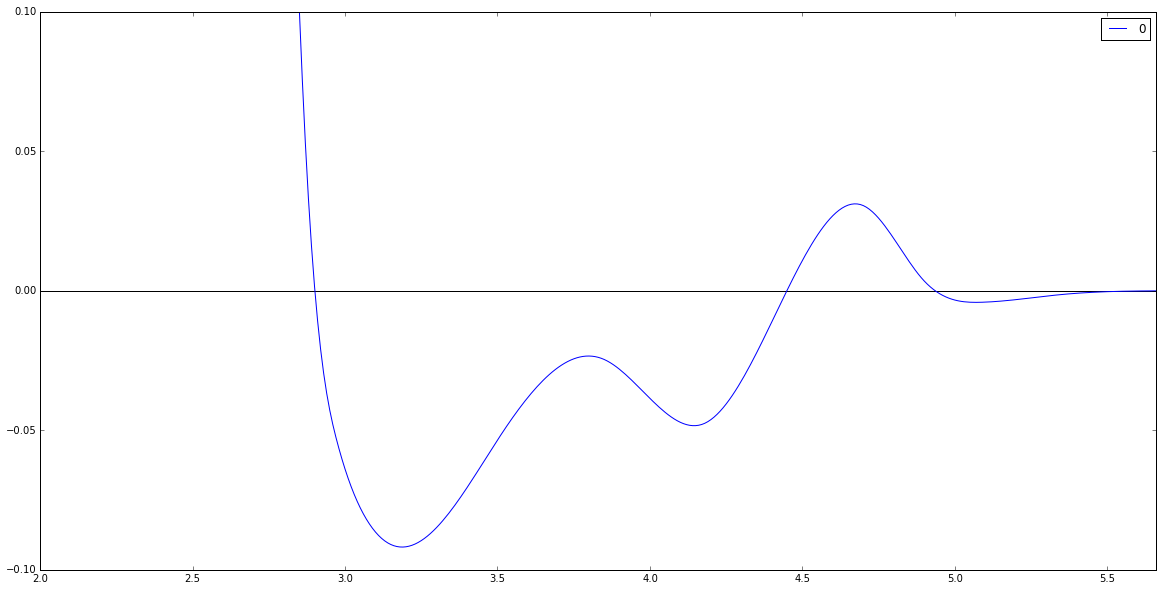

In [571]:
plt.figure(figsize=(20,10))
for i, para in enumerate(param_list[-1:]):
    knots_pairx = list(para['hyperparams']['pair'])
    coeff_pairx = list(para['params']['pair'])
    knots_edens = params['hyperparams']['edens']
    coeff_edens = params['params']['edens']
    embed = params['params']['embed']
    
    #rs = np.linspace(2, 5.82, 701)
    #rs = np.linspace(2.2, 5.66, 347)

    y_pairx = [f_spline3(r, coeff_pairx, knots_pairx) for r in rs]
#    y_edens = [f_spline3(r, coeff_edens, knots_edens) for r in rs]

#     print(knots_pairx)
#     print(coeff_pairx)
#     print(knots_edens)
#     print(coeff_edens)
#     print(embed)
    
#    plt.scatter(params['hyperparams']['pair'], np.zeros(len(params['hyperparams']['pair'])))
    if i == 1:
        plt.vlines(para['hyperparams']['pair'], -10, 10)
        plt.plot(rs, y_pair)
#    plt.vlines(params['hyperparams']['edens'], -10, 10, colors='m')
    
    plt.plot(rs, y_pairx, '-', label=str(i))
#    plt.plot(rs, y_edens, '.', label=str(i))
    
    plt.xlim(2.0, 5.66)
    plt.ylim(-0.1,.1)
    plt.hlines(xmin=2.0, xmax=6.0, y=0.0)

plt.legend()

In [20]:
with open(os.path.join(working, 'params_store' + '.pickle'), 'rb') as fi:
    model_params = pickle.load(fi)

In [21]:
model_params

[{'hyperparams': {u'edens': [2.5, 3.1000000000000001, 3.5, 4.9000000000000004],
   u'pair': [2.5648974999999998,
    2.6297950000000001,
    2.6946924999999999,
    2.8663175000000001,
    2.9730449999999999,
    3.0797724999999998,
    3.5164724999999999,
    3.8464450000000001,
    4.1764175000000003,
    4.7008450000000002,
    4.8952999999999998,
    5.0897550000000003,
    5.3429525,
    5.4016950000000001,
    5.4604375000000003]},
  'params': {'edens': array([-43.2896107 ,   4.64461212,   0.32332911,   0.05820618]),
   'embed': array([-4.18353755, -0.00963669]),
   'lrcorr': array([], dtype=float64),
   'pair': array([ -1.00171035e+02,   1.90025394e+01,   2.15938317e+01,
           -1.39759833e+01,   2.16332289e+01,  -3.29542126e+00,
            1.70455674e+00,   1.41347064e+00,  -9.02958785e-01,
           -8.62309098e-01,   1.95964588e+00,  -8.70527088e-01,
            3.22342700e-02,  -1.53866121e+00,   1.37095441e+00])}}]

In [ ]:
# fit function
def fit_spline
par_in = V_x_a
output = fmin(uloss, par_in, args=(r,), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
pair_new = output[0]
print(*pair_new)

### Tungsten EAM IFF functions and parameters from Marinica et al. (corrected)

In [158]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# electronic density function (cubic splines)
rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2
F_new = lambda d, a: a[0]*d**0.5 + a[1]*d**2


Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3
Fe = lambda d, a: F(d/S, a) + C/S*d
Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2)

# pair potential function (same spline form as electronic density)
V = rho

In [159]:
# electronic density parameters
rho_re_a = [3.704045964e-3]
rho_re_r = [5.46]

# embeding function parameters
F_re_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

# pair potential
V_re_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]

In [160]:
def utot_re(x):
    u = 6*V(x, V_re_a, V_re_r)
    d = 12*rho(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/12

def u_manybody_re(x):
    d = 12*rho(x, rho_re_a, rho_re_r)
    u = F(d, F_re_a)
    return u/12

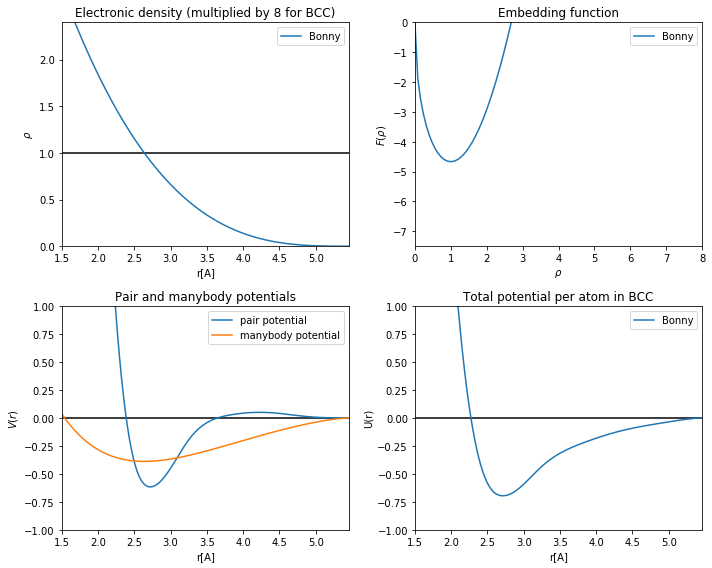

In [161]:
# plot the functions and potentials
rcut = 5.46
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_re_a, rho_re_r)*12 for x in r]
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, dens, label='Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [F(d, F_re_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='Bonny')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, V_re_a, V_re_r) for x in r]
pot_manybody = [u_manybody_re(x) for x in r]
plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot = [utot_re(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='Bonny')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

In [209]:
# electronic density parameters
rho_x_a = [1.0]
rho_x_r = [5.48]

# embeding function parameters
#F_re_a = [-7.046791948, 0, 1.143405627]
#F_x_a = [-7.046791948, 1.23658472, 1.143405627]
F_x_a = [-7.046791948, 0.0, 1.143405627]



#3.704045964e-3

# pair potential
V_x_a = [x*2 for x in V_re_a][:]
#V_x_r = [2.74, 3.25, 3.75, 4.5, 5.48]
#V_x_r = [2.75, 3.25, 3.75, 4.356, 5.0, 5.5]
V_x_r = [2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75]

V_x_a += [0.0, 0.0]
V_x_a

[13.453610618,
 6.435187778,
 -1.3091715174,
 0.2906458968,
 -0.4127258928,
 0.12229818232,
 0.0,
 0.0]

In [210]:
def utot_re(x):
    u = 6*V(x, V_re_a, V_re_r)
    d = 12*rho(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/12

def u_manybody_re(x):
    d = 12*rho(x, rho_re_a, rho_re_r)
    u = F(d, F_re_a)
    return u/12


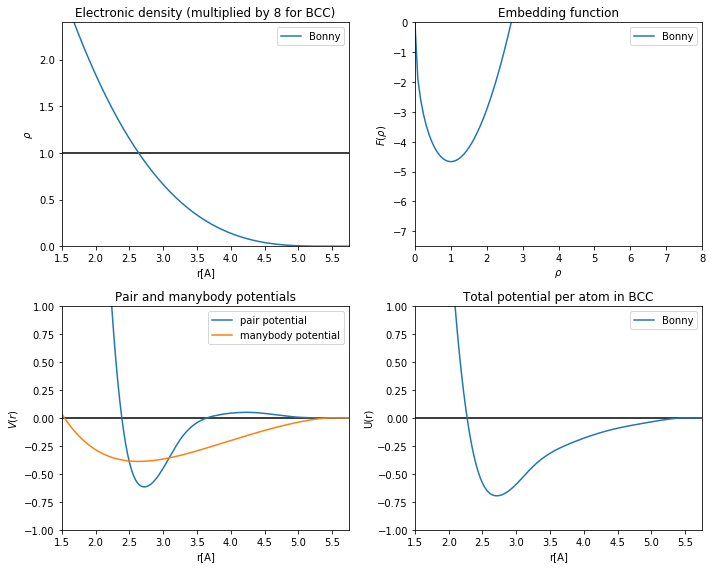

In [211]:
# plot the functions and potentials
rcut = 5.75
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_re_a, rho_re_r)*12 for x in r]
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, dens, label='Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [F(d, F_re_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='Bonny')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, V_re_a, V_re_r) for x in r]
pot_manybody = [u_manybody_re(x) for x in r]
plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot = [utot_re(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='Bonny')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

In [212]:
# fit pair potential
def udif(p, r):
    uref = [V(x, V_re_a, V_re_r) for x in r]
    utry = [V(x, p, V_x_r) for x in r]
    return uref, utry

def uloss(p, r):
    uref = [V(x, V_re_a, V_re_r) for x in r]
    utry = [V(x, p, V_x_r) for x in r]
    loss = sum([(a-b)**2 for a, b in zip(uref, utry)])
    return loss

In [213]:
par_in = V_x_a
output = fmin(uloss, par_in, args=(r,), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
pair_new = output[0]
print(*pair_new)

0.4527535290774057 7.091857873610367 1.6314949612839302 0.7906877956550405 -0.8249673243680319 0.14501087706040938 -0.002061634677032549 0.0021894588902290147


Text(0,0.5,'$V(r)$')

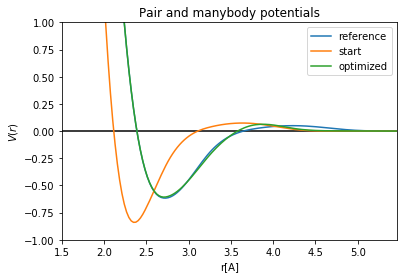

In [214]:
rcut = 5.46
r = np.linspace(0., rcut, 201)

uref, utry = udif(V_x_a, r)
uref, uopt = udif(pair_new, r)

plt.title('Pair and manybody potentials')
plt.plot(r, uref, label='reference')
plt.plot(r, utry, label='start')
plt.plot(r, uopt, label='optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

In [215]:
# fit manybody potential
def u_manybody_dif(p, r):
    uref = [F(12*rho(x, rho_re_a, rho_re_r), F_re_a)/12 for x in r]
    utry = [F_new(12*rho(x, rho_x_a, rho_x_r), p)/12 for x in r]
    return uref, utry

def u_manybody_loss(p, r):
    uref = [F(12*rho(x, rho_re_a, rho_re_r), F_re_a)/12 for x in r]
    utry = [F_new(12*rho(x, rho_x_a, rho_x_r), p)/12 for x in r]
    loss = sum([(a-b)**2 for a, b in zip(uref, utry)])
    return loss

In [216]:
rho_x_a = [1.0]
r = np.linspace(0., rcut, 201)
par_in = [F_re_a[0], F_re_a[2]]
output = fmin(u_manybody_loss, par_in, args=(r,), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
many_new = output[0]
print(*many_new)

-0.344540412587315 1.6869558429105695e-05


[-7.046791948, 1.23658472, 1.143405627]


Text(0,0.5,'$V(r)$')

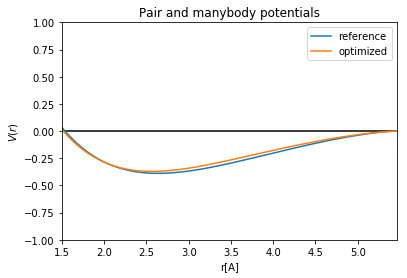

In [217]:
rcut = 5.46
r = np.linspace(0., rcut, 201)
print(F_re_a)
uref, utry = u_manybody_dif(F_re_a, r)
uref, uopt = u_manybody_dif(many_new, r)

plt.title('Pair and manybody potentials')
plt.plot(r, uref, label='reference')
#plt.plot(r, utry, label='start')
plt.plot(r, uopt, label='optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

In [218]:
many_x = list(many_new)
pair_x = list(pair_new)

In [219]:
print(many_x + pair_x)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [220]:
pars_in = {'pair':pair_x, 'embed':many_x}
with open('../data/working/pars_in.pickle', 'wb') as fo:
    pickle.dump(pars_in, fo)

In [188]:
def utot_opt(x, pn, mn):
    u = 6*V(x, pn, V_x_r)
    d = 12*rho(x, rho_x_a, rho_x_r)
    u += F_new(d, mn)
    return u/12

Text(0,0.5,'U(r)')

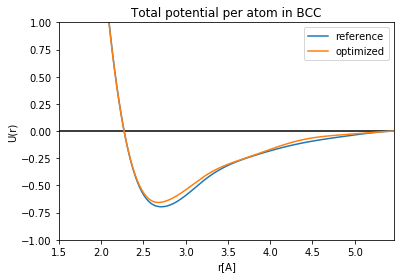

In [189]:
pot = [utot_re(x) for x in r]
pot_new = [utot_opt(x, pair_new, many_new) for x in r]

plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='reference')
plt.plot(r, pot_new, label='optimized')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

In [190]:
# modified functions
many_x = [x for x in many_new]
many_x[1] = 0.0

pair_x = [x for x in pair_new]
pair_x[-1] += 2*many_new[1]

In [191]:
print(pair_x)
print(many_x)

[7.262799609949834, 2.8551814788414784, -1.1750824011719558, 0.5925315310384949, -0.41006381316375573, 0.11876321014440062]
[-0.344540412587315, 0.0]


In [120]:
pair_new

array([ 0.83073149,  6.3064633 ,  2.56944634, -0.21327208, -0.2225459 ,
        0.02275643])

In [121]:
many_new

array([-4.09342761e-01,  3.54237104e-03,  1.53203715e-05])

In [96]:
many_x = [many_x[0], 0.0, 0.0]

Text(0,0.5,'U(r)')

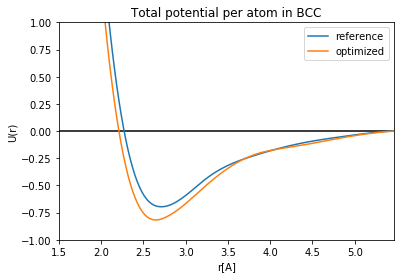

In [97]:
pot = [utot_re(x) for x in r]
pot_new = [utot_opt(x, pair_x, many_x) for x in r]

plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='reference')
plt.plot(r, pot_new, label='optimized')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

In [79]:
print('pair potentail parameters:', *pair_x)
print('embedding function parameters:', *many_x)

pair potentail parameters: 0.8307314918975489 6.306463298847209 2.569446338927059 -0.21327208205268988 -0.22254590199235236 0.02984117320348275
embedding function parameters: -0.4093427610992626 0.0 0.0


In [202]:
pwd

'/Users/l2v/work/force_fields/eam-models/notebooks'

In [22]:
%%writefile ../reports/parameters

Pair potential 
-1.00171035e+02,
1.90025394e+01,
2.15938317e+01,
-1.39759833e+01,
2.16332289e+01,
-3.29542126e+00,
1.70455674e+00,
1.41347064e+00,
-9.02958785e-01,
-8.62309098e-01,
1.95964588e+00,
-8.70527088e-01,
3.22342700e-02,
-1.53866121e+00,
1.37095441e+00,

(1,  0.960851701343041e2, 2.5648975),
(2, -0.184410923895214e3, 2.6297950),
(3,  0.935784079613550e2, 2.6946925),
(4, -0.798358265041677e1, 2.8663175),
(5,  0.747034092936229e1, 2.9730450),
(6, -0.152756043708453e1, 3.0797725),
(7,  0.125205932634393e1, 3.5164725),
(8,  0.163082162159425e1, 3.8464450),
(9, -0.141854775352260e1, 4.1764175),
(10,-0.819936046256149e0, 4.7008450),
(11, 0.198013514305908e1, 4.8953000),
(12,-0.696430179520267e0, 5.0897550),
(13, 0.304546909722160e-1,5.3429525),
(14,-0.163131143161660e1, 5.4016950),
(15, 0.138409896486177e1, 5.4604375)


Electronic density function
-4.32896107e+01,
4.64461212e+00,
3.23329113e-01,
5.82061842e-02,

[2.5, 3.1, 3.5, 4.9]

Embedding function parameters:
a_1^F: -4.18353755e+00
a_2^F: -9.63668936e-03

Writing ../reports/parameters
